In [150]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# $k$-th roots of permutations

Given $\sigma\in S_n$ and $k \geq 1$: list all $\gamma \in S_n$ such that $\gamma^k = \sigma$ (the product is just composition of permutations).

In [2]:
def antecedents_generator(m,k):
    """
    Generate all l such that l == m*gcd(k,l).
    """
    for a in divisors(k):
        l = m*a
        if gcd(l,k) == a:
            yield l

def integer_partitions_with_given_parts(N,Parts,decreasing_order=True):
    """
    Generate all lists L with sum(L) == N and L[i] in parts. If decreasing_order, then L with be non-increasing.
    """
    if Parts != 0 and min(Parts) <= 0:
        raise ValueError('All parts must be positives (strictly).')
    
    parts = list(Parts)
    if decreasing_order:
        parts.sort(reverse=True)
    front = [(N,[],0)]
    lp = len(parts)
    while len(front) != 0:
        M,L,i = front.pop()
        for j in range(i,lp):
            new_M = M - parts[j]
            if new_M > 0:
                front.insert(0,(new_M, L+[parts[j]], j))
            elif new_M == 0:
                yield Partition(L+[parts[j]])

def set_partitions_with_given_parts(S,Parts):
    """
    Generate all Partitions of S with parts of sizes precribed in Parts.
    """
    if type(S) in {int,type(1)}:
        s = int(S)
    else:
        s = len(S)
    for X in integer_partitions_with_given_parts(s,Parts):
        for P in SetPartitions(s,X):
            yield P

def merging_cycles(list_of_cycles):
    """
    Generate all l-cycles such that its k-th power is the product of cycles in Cycles (which conctains gcd(l,k) cycles of lenght l/gcd(l,k))
    """
    lC = len(list_of_cycles)
    lperm = len(list_of_cycles[0])
    l = lC*lperm
    Perm = [0 for i in range(l)]
    for j in range(lperm):
        Perm[j*lC] = list_of_cycles[0][j]
    for p in Permutations(lC-1):
        for indexes in cartesian_product([range(lperm) for _ in range(lC-1)]):
            new_Perm = list(Perm)
            for i in range(lC-1):
                for j in range(lperm):
                    new_Perm[(p[i] + (indexes[i]+j)*lC) %l] = list_of_cycles[i+1][j]
            gamma = Permutation(tuple(new_Perm))
            yield gamma

def rewind(L,k):
    """
    Construct the list M such that M[(j*k)%(len(M))] == L[j].
    """
    M = [0 for _ in L]
    m = len(M)
    for j in range(m):
        M[(j*k)%m] = L[j]
    return M

def sym_prod(L,n):
    """
    Return the product of all permutations in L as elements of Permutations(n).
    """
    p = Permutations(n).identity()
    for l in L:
        p *= l
    return p

def kth_roots(self,k=2):
    r"""
    Return all k-th roots of ``self`` (as a generator).
    
    A k-th root of the permutation ``self`` is a permutation `\gamma` such that `\gamma^k = self`.
    
    INPUT:
    
    - k -- optional integer (default 2), at least 1
    
    EXAMPLES::
    
        sage: Sigma = Permutations(5).identity()
        sage: list(kth_roots(Sigma,3))
        [[1, 4, 3, 5, 2], [1, 5, 3, 2, 4], [1, 2, 4, 5, 3], [1, 2, 5, 3, 4], [4, 2, 3, 5, 1], [5, 2, 3, 1, 4], [3, 2, 5, 4, 1], [5, 2, 1, 4, 3], [2, 5, 3, 4, 1], [5, 1, 3, 4, 2], [2, 3, 1, 4, 5], [3, 1, 2, 4, 5], [2, 4, 3, 1, 5], [4, 1, 3, 2, 5], [3, 2, 4, 1, 5], [4, 2, 1, 3, 5], [1, 3, 4, 2, 5], [1, 4, 2, 3, 5], [1, 3, 5, 4, 2], [1, 5, 2, 4, 3], [1, 2, 3, 4, 5]]
        
        sage: Sigma = Permutation('(1,3)')
        sage: list(kth_roots(Sigma))
        []
    
    For n >= 6, this algorithm begins to be more efficient than naive search (look at all permutations and test its k-th power).
    
    .. SEEALSO::
    
            * :meth:`has_kth_root`
            * :meth:`number_of_kth_roots`
    
    TESTS:
        
    We compute the number of square roots of the identity (i.e. involutions in `S_n`, :oeis:`A000085`)::
        
        sage: [len(list(kth_roots(Permutations(n).identity()))) for n in range(2,8)]
        [2, 4, 10, 26, 76, 232]
        
        sage: list(kth_roots(Permutations(4).identity(),-1))
        Traceback (most recent call last):
        ...
        ValueError: k must be at least 1
    """
    if k < 1:
        raise ValueError('k must be at least 1')
    P = Permutations(self.size())
    
    # Creating dict {length: cycles of this length in the cycle decomposition of self}
    Cycles = {}
    for c in self.cycle_tuples(singletons=True):
        lc = len(c)
        if lc not in Cycles:
            Cycles[lc] = []
        Cycles[lc].append(c)
    
    # for each length m, collects all product of cycles which k-th power gives the product prod(Cycles[l])
    Possibilities = {m: [] for m in Cycles}
    for m in Cycles:
        N = len(Cycles[m])
        parts = [x//m for x in antecedents_generator(m,k)]
        b = False
        for X in integer_partitions_with_given_parts(N,parts):
            for partition in SetPartitions(N,X):
                b = True
                poss = [P.identity()]
                for pa in partition:
                        poss = [p*q for p in poss for q in merging_cycles([rewind(Cycles[m][i-1],k//len(pa)) for i in pa])]
                Possibilities[m] += poss
        if not b:
            return
    
    #Product of Possibilities (i.e. final result)
    for L in cartesian_product(Possibilities.values()):
        yield P.prod(L)

Given $\sigma\in S_n$ and $k \geq 1$: list all $\gamma \in S_n$ such that $\gamma^k = \sigma$ (the product is just composition of permutations).

In [3]:
def has_integer_partitions_with_given_parts(N,Parts):
    """
    Generate all lists L with sum(L) == N and L[i] in Parts. If decreasing_order, then L with be non-increasing.
    """
    parts = list(Parts)
    front = [(N,[],0)]
    lp = len(parts)
    while len(front) != 0:
        M,L,i = front.pop()
        for j in range(i,lp):
            new_M = M - parts[j]
            if new_M > 0:
                front.insert(0,(new_M, L+[parts[j]], j))
            elif new_M == 0:
                return True
    return False

def has_kth_root(self,k=2):
    r"""
    Decide if ``self`` has a k-th roots.
    
    A k-th root of the permutation ``self`` is a permutation `\gamma` such that `\gamma^k = self`.
    
    INPUT:
    
    - k -- optional integer (default 2), at least 1
    
    EXAMPLES::
    
        sage: Sigma = Permutations(5).identity()
        sage: has_kth_roots(Sigma,3)
        True
        
        sage: Sigma = Permutation('(1,3)')
        sage: has_kth_roots(Sigma)
        False
    
    .. SEEALSO::
    
            * :meth:`kth_roots`
            * :meth:`number_of_kth_roots`
    
    TESTS:
        
    We compute the number of permutations that have square roots (i.e. squares in `S_n`, :oeis:`A003483`)::
        
        sage: [len([p for p in Permutations(n) if has_kth_root(p)]) for n in range(2,7)]
        [1, 3, 12, 60, 270]
        
        sage: has_kth_roots(Permutations(4).identity(),-1)
        Traceback (most recent call last):
        ...
        ValueError: k must be at least 1
    """
    if k < 1:
        raise ValueError('k must be at least 1')
    P = Permutations(self.size())
    
    # Creating dict {length: number of cycles of this length in the cycle decomposition of self}
    Cycles = {}
    for c in self.cycle_tuples(singletons=True):
        lc = len(c)
        if lc not in Cycles:
            Cycles[lc] = 0
        Cycles[lc] += 1
    
    # for each length m, check if the number of m-cycles can come from a k-th power (i.e. if you can partitionate m*Cycles[m] into parts of size l with l = m*gcd(l,k))
    for m in Cycles:
        N = Cycles[m]
        parts = [x//m for x in antecedents_generator(m,k)]
        if not has_integer_partitions_with_given_parts(N,parts):
            return False
    return True

Given $\sigma\in S_n$ and $k \geq 1$: list all $\gamma \in S_n$ such that $\gamma^k = \sigma$ (the product is just composition of permutations).

In [4]:
def number_of_kth_roots(self,k=2):
    r"""
    Return the number of k-th roots of ``self``.
    
    A k-th root of the permutation ``self`` is a permutation `\gamma` such that `\gamma^k = self`.
    
    INPUT:
    
    - k -- optional integer (default 2), at least 1
    
    EXAMPLES::
    
        sage: Sigma = Permutations(5).identity()
        sage: number_of_kth_roots(Sigma,3)
        21
        
        sage: Sigma = Permutation('(1,3)')
        sage: number_of_kth_roots(Sigma)
        0
    
    .. SEEALSO::
    
            * :meth:`kth_roots`
            * :meth:`has_kth_root`
    
    TESTS:
        
    We compute the number of square roots of the identity (i.e. involutions in `S_n`, :oeis:`A000085`), then the number of cubic roots::
        
        sage: [number_of_kth_roots(Permutations(n).identity()) for n in range(2,10)]
        [2, 4, 10, 26, 76, 232, 764, 2620]
        
        sage: [number_of_kth_roots(Permutations(n).identity(),3) for n in range(2,10)]
        [1, 3, 9, 21, 81, 351, 1233, 5769]
        
        sage: list(kth_roots(Permutations(4).identity(),-1))
        Traceback (most recent call last):
        ...
        ValueError: k must be at least 1
    """
    if k < 1:
        raise ValueError('k must be at least 1')
    P = Permutations(self.size())
    
    # Creating dict {length: number of cycles of this length in the cycle decomposition of Sigma}
    Cycles = {}
    for c in self.cycle_tuples(singletons=True):
        lc = len(c)
        if lc not in Cycles:
            Cycles[lc] = 0
        Cycles[lc] += 1
    
    # for each length m, count the number of products of cycles which k-th power gives the product prod(Cycles[l])
    Counts = {m: 0 for m in Cycles}
    for m in Cycles:
        N = Cycles[m]
        parts = [x//m for x in antecedents_generator(m,k)]
        b = False
        for partition in integer_partitions_with_given_parts(N,parts,decreasing_order=True):
            b = True
            count = SetPartitions(N,partition).cardinality()
            for x in partition:
                count *= factorial(x-1) * m**(x-1)
            Counts[m] += count
        if not b:
            return 0
    
    #Product of Possibilities (i.e. final result)
    return prod(Counts.values())

## Examples

### $k$-th roots of identity (elements of order $k$ in $S_n$)

In [238]:
[number_of_kth_roots(Permutations(n).identity(),5) for n in range(2,50)]

[1,
 1,
 1,
 25,
 145,
 505,
 1345,
 3025,
 78625,
 809425,
 4809025,
 20787625,
 72696625,
 1961583625,
 28478346625,
 238536558625,
 1425925698625,
 6764765838625,
 189239120970625,
 3500701266525625,
 37764092547420625,
 288099608198025625,
 1725747644222610625,
 49986265230635280625,
 1112799169747815030625,
 14662555575762335280625,
 136010110548770728530625,
 984042502919761589655625,
 29477413354747406792640625,
 761387683281280308735315625,
 11833963151873965419252090625,
 129216128959885054970322690625,
 1095624590227324516939318890625,
 33904693111981702214911357890625,
 990694911430569789384058384890625,
 17720605298497832181889123943265625,
 222538506990232435114248214399140625,
 2163503206053351456343267988274765625,
 69092181121739919189431446336957890625,
 2242042772057094472432849745420659140625,
 45311619537950105633870727707048895390625,
 643121261635951300729977991011748339140625,
 7051071597453009778185722849403480157890625,
 2321550559044285882554139213699243748035

In [8]:
n = 8
k = 3

ge = kth_roots(Permutations(n).identity(),3)
for _ in range(20):
    gamma = next(ge)
    print(gamma, gamma^k == Permutations(n).identity())

[1, 4, 3, 5, 2, 7, 8, 6] True
[1, 4, 3, 5, 2, 8, 6, 7] True
[1, 5, 3, 2, 4, 7, 8, 6] True
[1, 5, 3, 2, 4, 8, 6, 7] True
[1, 2, 4, 5, 3, 7, 8, 6] True
[1, 2, 4, 5, 3, 8, 6, 7] True
[1, 2, 5, 3, 4, 7, 8, 6] True
[1, 2, 5, 3, 4, 8, 6, 7] True
[4, 2, 3, 5, 1, 7, 8, 6] True
[4, 2, 3, 5, 1, 8, 6, 7] True
[5, 2, 3, 1, 4, 7, 8, 6] True
[5, 2, 3, 1, 4, 8, 6, 7] True
[3, 2, 5, 4, 1, 7, 8, 6] True
[3, 2, 5, 4, 1, 8, 6, 7] True
[5, 2, 1, 4, 3, 7, 8, 6] True
[5, 2, 1, 4, 3, 8, 6, 7] True
[2, 5, 3, 4, 1, 7, 8, 6] True
[2, 5, 3, 4, 1, 8, 6, 7] True
[5, 1, 3, 4, 2, 7, 8, 6] True
[5, 1, 3, 4, 2, 8, 6, 7] True


### Some timeit tests

In [235]:
n = 10
k = 3
Sigma = Permutations(n).identity()
# 31041 kth roots

In [234]:
number_of_kth_roots(Sigma,k)

31041

In [75]:
%%timeit
sum(1 for _ in kth_roots(Sigma,k))

7 s ± 334 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%%timeit
sum(1 for p in Permutations(n) if p^k == Sigma)

42.1 s ± 350 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
n = 10
k = 3
Sigma = Permutations(n).identity()

In [76]:
%%timeit
has_kth_root(Sigma,k)

20.3 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [77]:
%%timeit
number_of_kth_roots(Sigma,k)

336 µs ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Acyclic orientations of graphs

Given a (di)graph $G$, enumerate all its acyclic orientations (i.e. oriented graphs which underlying graph is $G$ and which doesn't have cycle).

In [79]:
class AcyclicOrientations():
    """
    Class of acyclic orientations of a (di)graph.
    
    EXAMPLES::
            
            sage: G = graphs.CompleteGraph(5)
            sage: len(list(AcyclicOrientations(G))
            120
            
            sage: G = graphs.PetersenGraph()
            sage: len(list(AcyclicOrientations(G))
            16680
            
    """
    # has_vertex when called add_edge ?
    # Show results, not only length + how to construct a DiGraph from the result ?
    # Document as_reoriention argument
    # Note on the algorithm + psossible improvement : block-and-cut graphs + topological order
    # Tests :  Graph(), Graph with 1 element, not a graph, non-connected graph
    def __init__(self,G,as_reorientation=False):
        self.V, self.E = G.vertices(), G.edges()
        self.l_V, self.l_E = len(self.V), len(self.E)
        self.D = DiGraph()
        self.D.add_vertices(self.V)
        self.mark, self.mem = 0, 0
        self.direction = 'f'
        self.A, self.Q, self.o = [], [], 1
        self.stop = False
        self.as_reorientation = as_reorientation
    
    def __iter__(self):
        return self
    
    def __next__(self):
        # Look at %prun
        while not self.stop:
#             print(self.mark,self.o,self.A,self.Q,self.D.edges())
            if self.direction == 'f':
                if self.mark == self.l_E:
                    if self.as_reorientation:
                        output = {self.E[i] : self.Q[i] for i in range(self.l_E)}
                    else:
                        output = list(self.A)
                    if self.Q[-1] == 1:
                        self.Q.pop(-1)
                        self.D.delete_edge(self.A.pop(-1))
                        self.o = -1
                        self.mark -= 1
                    else:
                        self.direction = 'b'
                    return output
                else:
                    u, v, lab = self.E[self.mark]
                    if self.o == -1:
                        u, v = v, u
                    
                    if self.is_flipable((u,v)):
                        self.D.add_edge((u,v))
                        self.A.append((u,v))
                        self.Q.append(self.o)
                        self.mark += 1
                        self.o = 1
                    
                    elif self.o == 1:
                        self.o = -1
                    else:
                        self.direction = 'b'
            elif self.direction == 'b':
                to_del = []
                while self.mark > 0 and self.Q[-1] == -1:
                    self.Q.pop(-1)
                    to_del.append(self.A.pop(-1))
#                     self.D.delete_edge(self.A.pop(-1))
                    self.mark -= 1
                if self.mark > 0:
                    self.Q.pop(-1)
                    self.D.delete_edges(to_del + [self.A.pop(-1)])
                    self.o = -1
                    self.mark -= 1
                    self.direction = 'f'
                else:
                    self.stop = True
        raise StopIteration
    
    def is_flipable(self,e):
#         self.D.add_edge(e)
        return not self.D.shortest_path(e[1],e[0]) # Need a method 'has_directed_path(v,u)' to improve (i.e. look if there is a path v -> u): doesn't exists yet (maybe use dfs implemented methods?).
        


#     def is_flipable_naive(self,e):
#         self.D.add_edge(e)
#         bb = self.D.is_directed_acyclic() # Need a method 'has_directed_path(v,u)' to improve (i.e. look if there is a path v ->u): doesn't exists yet (maybe use dfs implemented methods?).
#         return bb

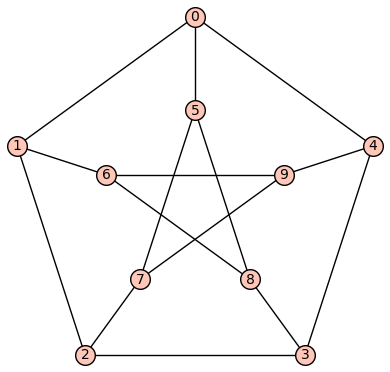

In [239]:
G = graphs.PetersenGraph()
G.show()

A = AcyclicOrientations(G)

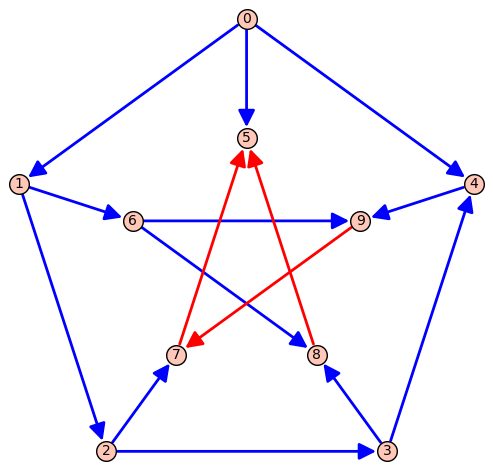

In [263]:
A1 = next(A)
D = DiGraph(A1, pos = G.get_pos()) # Give to D the same embeffing as G
d = D.graphplot(edge_colors = {'blue':[e for e in D.edges() if e[0] < e[1]], 'red':[e for e in D.edges() if e[0] > e[1]]})
d.plot()

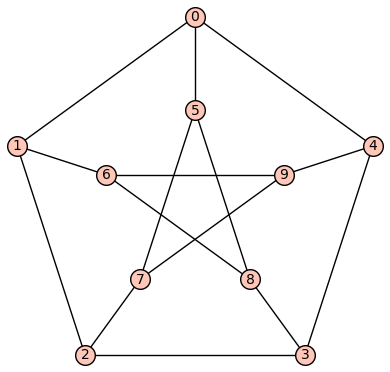

16680

In [184]:
G = graphs.PetersenGraph()
G.show()

A = AcyclicOrientations(G)
sum(1 for _ in A)

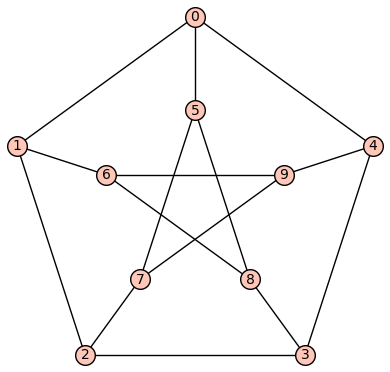

16680

In [264]:
G = graphs.PetersenGraph()
G.show()

A = AcyclicOrientations(G)
sum(1 for _ in A)

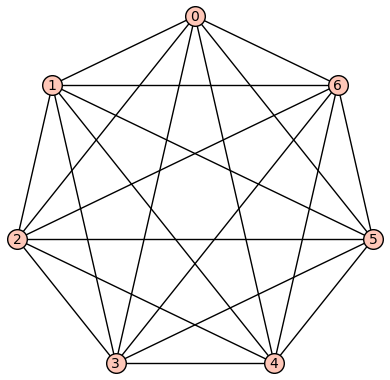

5040

In [265]:
n = 7
G = graphs.CompleteGraph(n)
G.show()

A = AcyclicOrientations(G)
sum(1 for _ in A)

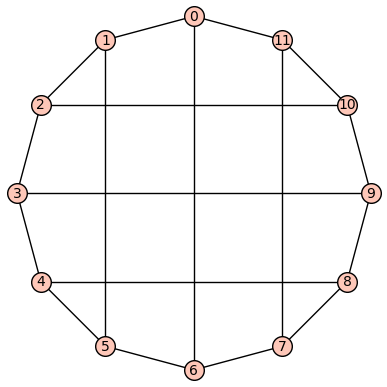

116784

In [266]:
G = graphs.BidiakisCube()
G.show()

A = AcyclicOrientations(G)
sum(1 for _ in A)

## Some timeit tests

In [188]:
%%timeit
sum(1 for _ in AcyclicOrientations(graphs.PetersenGraph()))

700 ms ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [189]:
%%timeit
sum(1 for _ in AcyclicOrientations(graphs.CompleteGraph(7)))

631 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [190]:
%%timeit
sum(1 for _ in AcyclicOrientations(graphs.BidiakisCube()))

4.99 s ± 65.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Thank you!

k-th have been pull-requested (https://github.com/sagemath/sage/pull/35053).

Acyclic orientations will be soon!

# Thousand thanks to the organizers & experts!
# &#128571; &#128571; &#128571;